In [24]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay

import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
import utils.ssvep_analysis as sa

In [25]:
def read_data(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    marker = df.to_numpy()[:, -1].flatten()
    return eeg_data, marker, severity

def preprocess_data(eeg_data, marker):
    eeg_data = sa.apply_ransac_detrending(eeg_data,)
    eeg_data = sa.filter_extreme_values(eeg_data)
    eeg_data = sa.apply_lowpass_filter(eeg_data)
    eeg_data = sa.apply_highpass_filter(eeg_data)
    eeg_data = sa.apply_notch_filter(eeg_data)

    cca_r_values = {}
    for distinct_marker in np.unique(marker):
        cca, target = sa.compute_cca(eeg_data[marker == distinct_marker])
        x, y = cca.transform(eeg_data[marker == distinct_marker], target)
        r = np.corrcoef(x.T, y.T)[0, 1]
        cca_r_values[distinct_marker] = r

    return cca_r_values

def build_dataset(directory_list):
    data_set = []
    for idx, directory in enumerate(directory_list):
        for file in os.listdir('../data/' + directory):
            file_path = '../data/' + directory + '/' + file
            eeg_data, marker, severity = read_data(file_path)
            measurement = preprocess_data(eeg_data, marker)
            measurement['group'] = idx
            measurement['severity'] = severity
            data_set.append(measurement)
    return pd.DataFrame(data_set)


directory_list = ['2024-01-12', '2024-01-19', '2024-01-22']

df = build_dataset(directory_list)
df.dropna(inplace=True)
df

,deuteranomaly-1-0.25,deuteranomaly-1-1,deuteranomaly-3-0.25,deuteranomaly-3-1,grey,group,severity
0,0.375574,0.244799,0.447660,0.401223,0.060175,0,0.00
1,0.365784,0.368309,0.457377,0.448446,0.094649,0,0.00
2,0.287945,0.324775,0.495948,0.272126,0.108339,0,0.00
3,0.339754,0.338491,0.389700,0.257414,0.099423,0,0.00
4,0.231314,0.435886,0.449056,0.377003,0.091775,0,0.00
...,...,...,...,...,...,...,...
87,0.141512,0.224627,0.186017,0.263154,0.091804,2,0.82
88,0.193491,0.255990,0.160883,0.255026,0.101418,2,0.83
89,0.184553,0.128167,0.169687,0.236808,0.126271,2,0.86
90,0.134799,0.204358,0.141477,0.172657,0.096637,2,0.87


In [26]:
X = df.drop(columns=['group', 'severity'])
groups = df['group']
y = np.where(df['severity'] > 0, 1, 0)

In [27]:
X_train, X_test, y_train, y_test, groups_train, groups_test = X, X, y, y, groups, groups # train_test_split(X, y, groups, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
])

cv = LeaveOneGroupOut()
cv_scores = cross_val_score(pipeline, X_train, y_train, groups=groups_train, cv=cv)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean():.2%}')

Cross-validation scores: [1.         0.90322581 0.83333333]
Mean cross-validation score: 91.22%


Accuracy: 97.80%
AUC ROC: 1.00


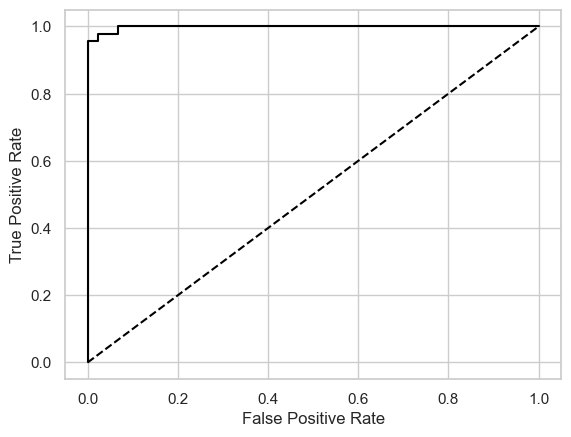

In [28]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:.2%}')

y_pred_proba = pipeline.predict_proba(X)
auc_roc = roc_auc_score(y, y_pred_proba[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

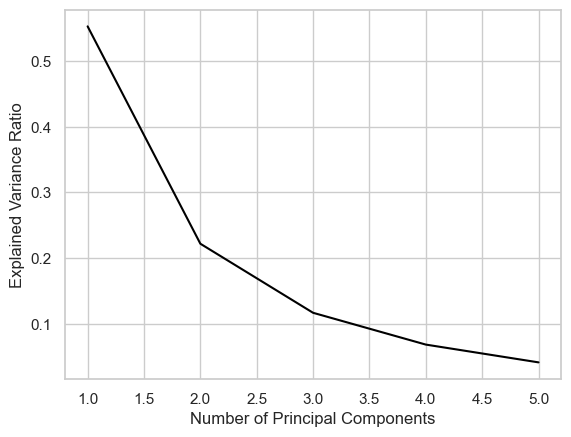

In [29]:
pca = pipeline.named_steps['pca']

explained_variance_ratio = pca.explained_variance_ratio_
num_components = len(explained_variance_ratio)
plt.plot(range(1, num_components + 1), explained_variance_ratio, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

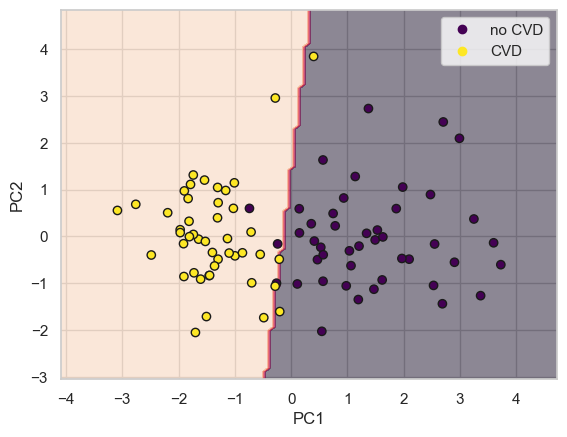

In [30]:
X_reduced = pipeline.named_steps['scaler'].transform(X)
X_reduced = pipeline.named_steps['pca'].transform(X_reduced)
X_reduced = X_reduced[:,:2]

model = pipeline.named_steps['log_reg']
model.fit(X_reduced, y)
disp = DecisionBoundaryDisplay.from_estimator(
    model, X_reduced, response_method="predict",
    xlabel='PC1', ylabel='PC2',
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', cmap='viridis')
disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD'])

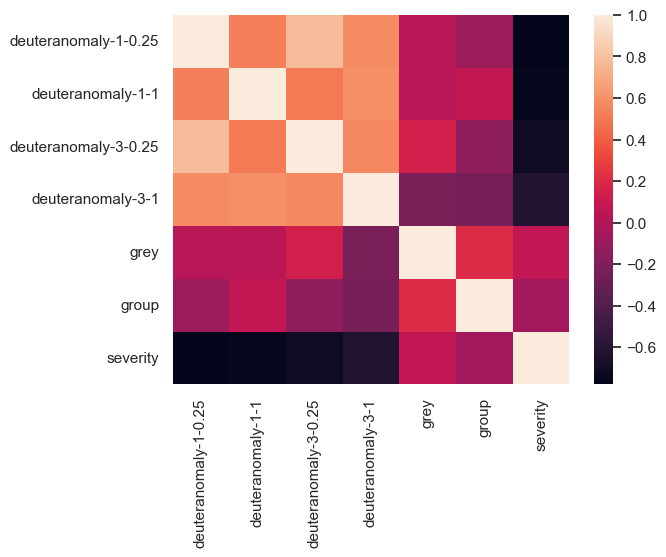

In [31]:
sns.heatmap(df.corr());

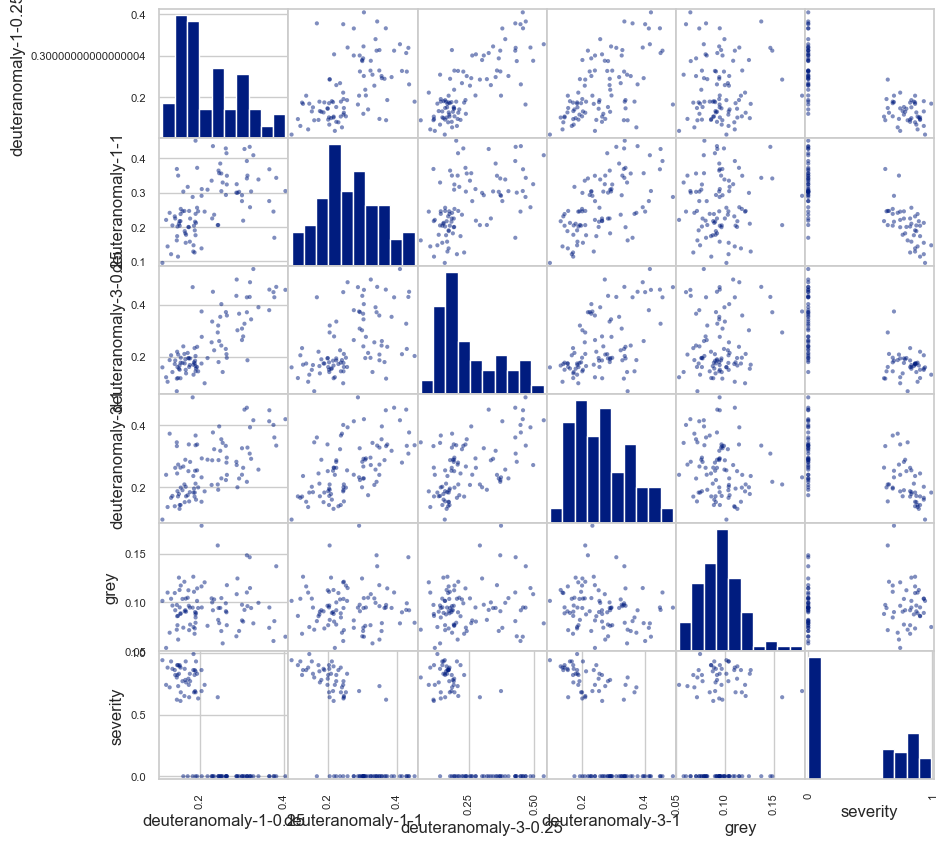

In [32]:
pd.plotting.scatter_matrix(df.drop(columns='group'), figsize=(10, 10));